In [220]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


# Goal

The goal of this notebook is to calculate
 * the beam center
 * pixel resolution
for all the apertures measured (0, 60, 120, 180, 240 and 300)

This notebooks takes **the profile files** produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


In [117]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.core.display import display

import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

/var/folders/t8/307ghqxx5djb28nl56mkmx7j90c0xy/T/ipykernel_2951/3697657416.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


In [8]:
base_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/beam_center_for_all_apertures"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Loading all the data

In [10]:
list_profile_files = glob.glob(base_folder + '/*.txt')
assert len(list_profile_files) > 0
print(f"{list_profile_files =}")

list_profile_files =['/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/beam_center_for_all_apertures/horizontal_profile.txt', '/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/beam_center_for_all_apertures/vertical_profile.txt']


## load profiles 

In [18]:
def cleaning_list_name_columns(list_name_columns):
    clean_list_name_columns = []
    for _index_column, _line in enumerate(list_name_columns):
        _line_no_space = _line.replace(" ", "")
        file_name, col_name = _line_no_space.split("->")
        various_part_of_file_name = file_name.split("/")
        clean_list_name_columns.append(various_part_of_file_name[-1])
    return clean_list_name_columns

In [43]:
# raw_data_dict = {'horizontal_profile.txt': {'profiles': {'0deg_30s_frames_OB_median.tif': [],
#                                                          '0deg_nbr1_30s_frames_OB_median.tif': [],
#                                                          ...},
#                                             'xaxis': []},
#                  'vertical_profile.txt': ...
#                 }

raw_data_dict = {}
total_number_of_fitting_step = 0

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=26)
    pd_metadata = pd.read_csv(_file, skiprows=5, nrows=19)
    list_names_of_columns = list(pd_metadata.columns)
    list_label_columns = list(pd_metadata.loc[:, list_names_of_columns[0]])
    clean_list_label_columns = cleaning_list_name_columns(list_label_columns)
    
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    
    _dict = {}
    for _index, _col_name in enumerate(list_names_of_columns[1:]):
        profile = np.asarray(pd_data.loc[:, _col_name])
        _dict[clean_list_label_columns[_index]] = profile
        total_number_of_fitting_step += 1
    
    raw_data_dict[base_file_name] = {'profiles': _dict,
                                     'xaxis': xaxis}

In [44]:
pprint.pprint(raw_data_dict)

{'horizontal_profile.txt': {'profiles': {'0deg_30s_frames_OB_median.tif': array([3610.6667, 3579.0833, 3583.8333, ..., 4129.0835, 4106.6665,
       4145.8335]),
                                         '0deg_nbr1_30s_frames_OB_median.tif': array([3689.8333, 3705.1667, 3657.    , ..., 4156.    , 4166.1665,
       4194.8335]),
                                         '0deg_nbr2_30s_frames_OB.tif': array([3711.5   , 3495.1667, 3576.5   , ..., 4079.3333, 4100.6665,
       4038.6667]),
                                         '120deg_30s_frames_OB_median.tif': array([761.0833, 738.    , 762.9167, ..., 950.0833, 922.1667, 938.75  ]),
                                         '120deg_again_30s_frames_OB_median.tif': array([ 759.6667,  728.1667,  752.8333, ..., 1013.8333,  991.1667,
        937.6667]),
                                         '120deg_nbr1_30s_frames_OB.tif': array([ 840.6667,  858.5   ,  842.5   , ..., 1051.8334, 1014.3333,
        962.8333]),
                                  

# fitting horizontal and vertical profile

In [45]:
estimated_center = {'horizontal_profile.txt': 4456,    # 4456
                    'vertical_profile.txt': 2912}

In [54]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

progress_bar = widgets.IntProgress()
progress_bar.max = total_number_of_fitting_step
display(progress_bar)

master_profile_fitted_dict = {}
for _profile_type in raw_data_dict.keys():
    # _key being the profile file name
    
    xaxis = raw_data_dict[_profile_type]['xaxis']
   
    profile_dict = {}
    for _aperture_filename in raw_data_dict[_profile_type]['profiles'].keys():
    
        yaxis = raw_data_dict[_profile_type]['profiles'][_aperture_filename]

        pars = mod.make_params(c=yaxis.mean(),
                      center=estimated_center[_profile_type],
                      sigma=xaxis.std(),
                      amplitude=xaxis.std() * yaxis.ptp())
        out = mod.fit(yaxis, pars, x=xaxis)

        profile_dict[_aperture_filename] = {'center_value': round(out.params['center'].value),
                                            'center_error': out.params['center'].stderr,
                                            'fitting': out.best_fit,
                                            }
        
        progress_bar.value += 1
    
    master_profile_fitted_dict[_profile_type] = profile_dict

progress_bar.close()
print("Fitting done!")

IntProgress(value=0, max=38)

[3610.6667 3579.0833 3583.8333 ... 4129.0835 4106.6665 4145.8335]
[3689.8333 3705.1667 3657.     ... 4156.     4166.1665 4194.8335]
[3711.5    3495.1667 3576.5    ... 4079.3333 4100.6665 4038.6667]
[761.0833 738.     762.9167 ... 950.0833 922.1667 938.75  ]
[ 759.6667  728.1667  752.8333 ... 1013.8333  991.1667  937.6667]
[ 840.6667  858.5     842.5    ... 1051.8334 1014.3333  962.8333]
[813.6667 837.1667 736.3333 ... 936.6667 929.5    853.8333]
[492.83334 478.66666 488.75    ... 555.9167  556.5833  561.3333 ]
[530.     506.5    522.     ... 540.8333 562.5    611.3333]
[464.16666 524.5     505.16666 ... 538.3333  545.      562.8333 ]
[515.5     484.33334 537.1667  ... 592.6667  572.5     511.33334]
[331.41666 322.83334 327.16666 ... 369.75    336.5     349.33334]
[338.33334 335.      339.5     ... 328.      327.66666 361.83334]
[362.      296.16666 353.83334 ... 299.16666 328.5     352.16666]
[6978.     6782.8335 6709.8335 ... 8927.     8891.167  8969.167 ]
[1614.     1583.     1592.83

## display the profiles fitted

In [58]:
master_profile_fitted_dict

{'horizontal_profile.txt': {'0deg_30s_frames_OB_median.tif': {'center_value': 4779,
   'center_error': 0.7610198026952473,
   'fitting': array([3451.63591367, 3453.9199828 , 3456.20522009, ..., 4351.96603733,
          4349.28379889, 4346.6025731 ])},
  '0deg_nbr1_30s_frames_OB_median.tif': {'center_value': 4780,
   'center_error': 0.9044121664819285,
   'fitting': array([3479.21547036, 3481.55655691, 3483.89879188, ..., 4398.91558825,
          4396.18574538, 4393.45688252])},
  '0deg_nbr2_30s_frames_OB.tif': {'center_value': 4781,
   'center_error': 1.1538179496654029,
   'fitting': array([3460.8809417 , 3463.14935019, 3465.41893993, ..., 4365.22756028,
          4362.55185987, 4359.87718864])},
  '120deg_30s_frames_OB_median.tif': {'center_value': 4656,
   'center_error': None,
   'fitting': array([885.88037193, 886.545948  , 887.21130854, ..., 960.70808251,
          960.06699206, 959.42568581])},
  '120deg_again_30s_frames_OB_median.tif': {'center_value': 4653,
   'center_error': 

<IPython.core.display.Javascript object>


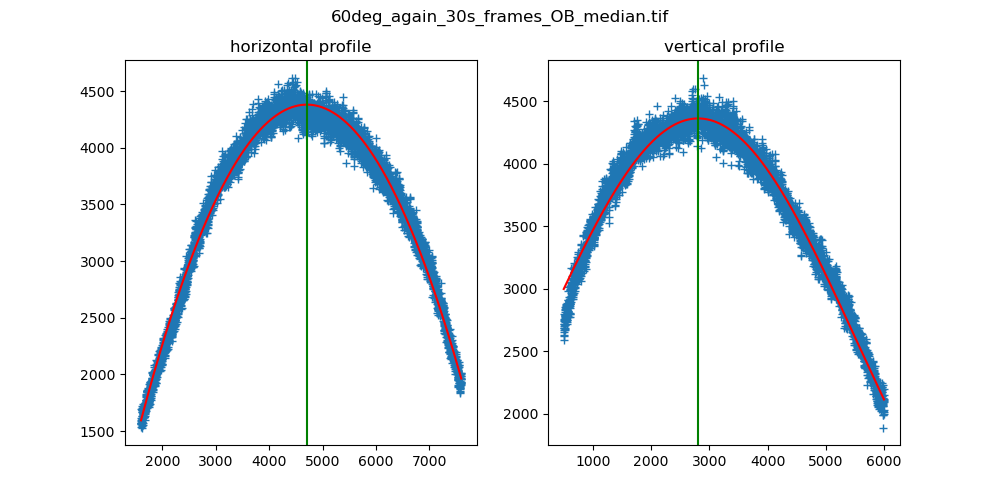

interactive(children=(Dropdown(description='aperture', options=('0deg_30s_frames_OB_median.tif', '0deg_nbr1_30…

In [81]:
fig, axes = plt.subplots(num=1, figsize=(10, 5), nrows=1, ncols=2)

def plot(aperture):

    aperture_file_name = aperture
    fig.suptitle(aperture)
   
    # horizontal
    axes[0].clear()
    horizontal_xaxis = raw_data_dict['horizontal_profile.txt']['xaxis']
    horizontal_yaxis = raw_data_dict['horizontal_profile.txt']['profiles'][aperture_file_name]
    fitted_horizontal_yaxis = master_profile_fitted_dict['horizontal_profile.txt'][aperture_file_name]['fitting']
    center_value = master_profile_fitted_dict['horizontal_profile.txt'][aperture_file_name]['center_value']
    axes[0].plot(horizontal_xaxis, horizontal_yaxis, '+')
    axes[0].plot(horizontal_xaxis, fitted_horizontal_yaxis, 'r')
    axes[0].axvline(center_value, color='green')
    axes[0].set_title("horizontal profile")

    # vertical
    axes[1].clear()
    vertical_xaxis = raw_data_dict['vertical_profile.txt']['xaxis']
    vertical_yaxis = raw_data_dict['vertical_profile.txt']['profiles'][aperture_file_name]
    fitted_vertical_yaxis = master_profile_fitted_dict['vertical_profile.txt'][aperture_file_name]['fitting']
    center_value = master_profile_fitted_dict['vertical_profile.txt'][aperture_file_name]['center_value']
    axes[1].plot(vertical_xaxis, vertical_yaxis, '+')
    axes[1].plot(vertical_xaxis, fitted_vertical_yaxis, 'r')
    axes[1].axvline(center_value, color='green')
    axes[1].set_title("vertical profile")

display_profiles = interactive(plot,
                              aperture = widgets.Dropdown(options=clean_list_label_columns))
display(display_profiles)
    
    
    

## Let's plot the center of the beam found over the image 

In [83]:
base_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/experimental_data_to_use/"
list_images_to_load = [os.path.join(base_folder, _file) for _file in clean_list_label_columns]
assert len(list_images_to_load) > 0

In [96]:
progress_bar = widgets.IntProgress()
progress_bar.max = len(list_images_to_load)
display(progress_bar)

images = {}
for _image_filename in list_images_to_load:
    _key = os.path.basename(_image_filename)
    image = np.asarray(Image.open(_image_filename))
    images[_key] = image
    progress_bar.value += 1
    
progress_bar.close()
print("All images have been loaded!")

IntProgress(value=0, max=19)

All images have been loaded!


<IPython.core.display.Javascript object>


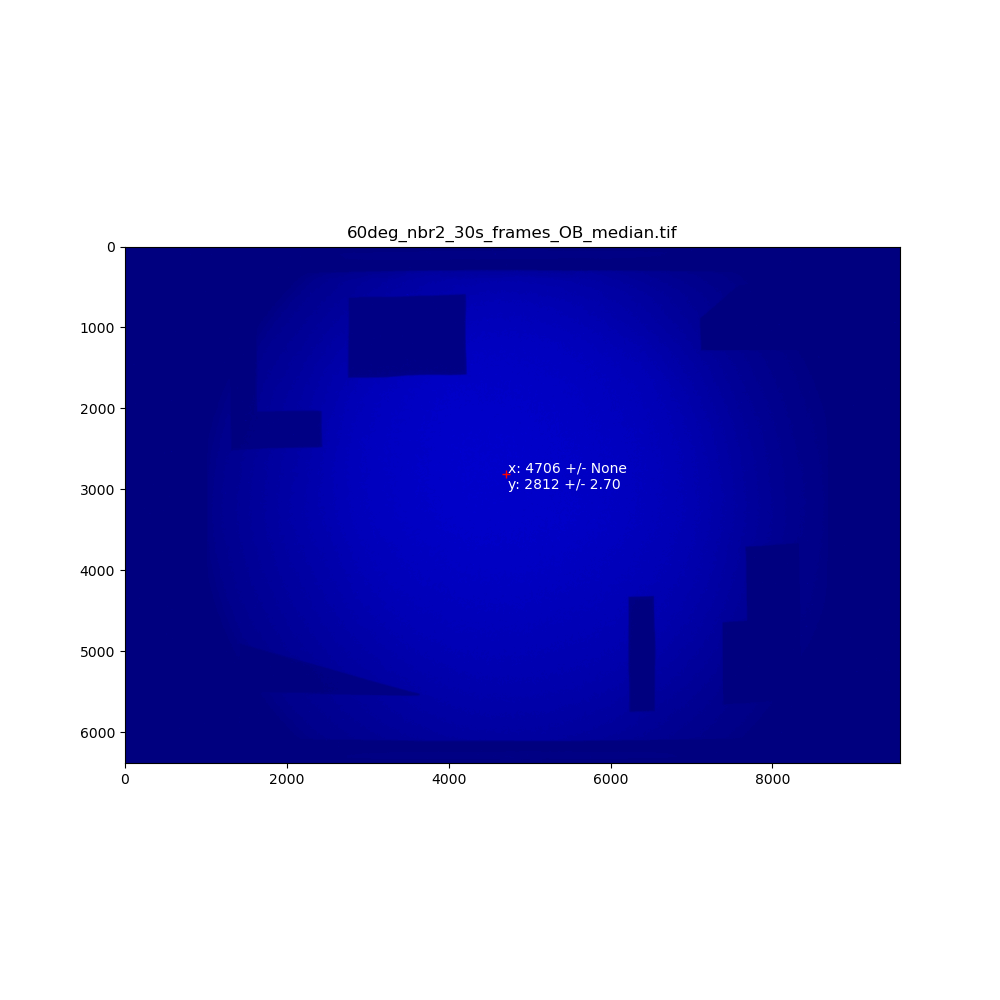

interactive(children=(Dropdown(description='filename', options=('0deg_30s_frames_OB_median.tif', '0deg_nbr1_30…

In [107]:
text_offset = 30

figure = plt.figure(num='Visualize image center', figsize=(10, 10))

def plot_center(filename):

 
    center_x = master_profile_fitted_dict['horizontal_profile.txt'][filename]['center_value']
    center_x_error = master_profile_fitted_dict['horizontal_profile.txt'][filename]['center_error']
    center_y = master_profile_fitted_dict['vertical_profile.txt'][filename]['center_value']
    center_y_error = master_profile_fitted_dict['vertical_profile.txt'][filename]['center_error']
    
    image = images[filename]
    plt.cla()
    plt.title(filename)
    plt.imshow(image, cmap='jet')
    plt.plot(center_x, center_y, 'r+')
    plt.text(center_x+text_offset, center_y+text_offset,
             f"x: {center_x} +/- {center_x_error}\ny: {center_y} +/- {center_y_error:.2f}",
                     horizontalalignment='left',
             verticalalignment='center',
             color='white'
    )

v = interactive(plot_center,
               filename = widgets.Dropdown(options=clean_list_label_columns))
display(v)




## Let's display all the center at the same time (using 300deg image as a reference) 

In [109]:
def filename_starts_with(filename):
    split_filename = filename.split("_")
    return split_filename[0]

<IPython.core.display.Javascript object>


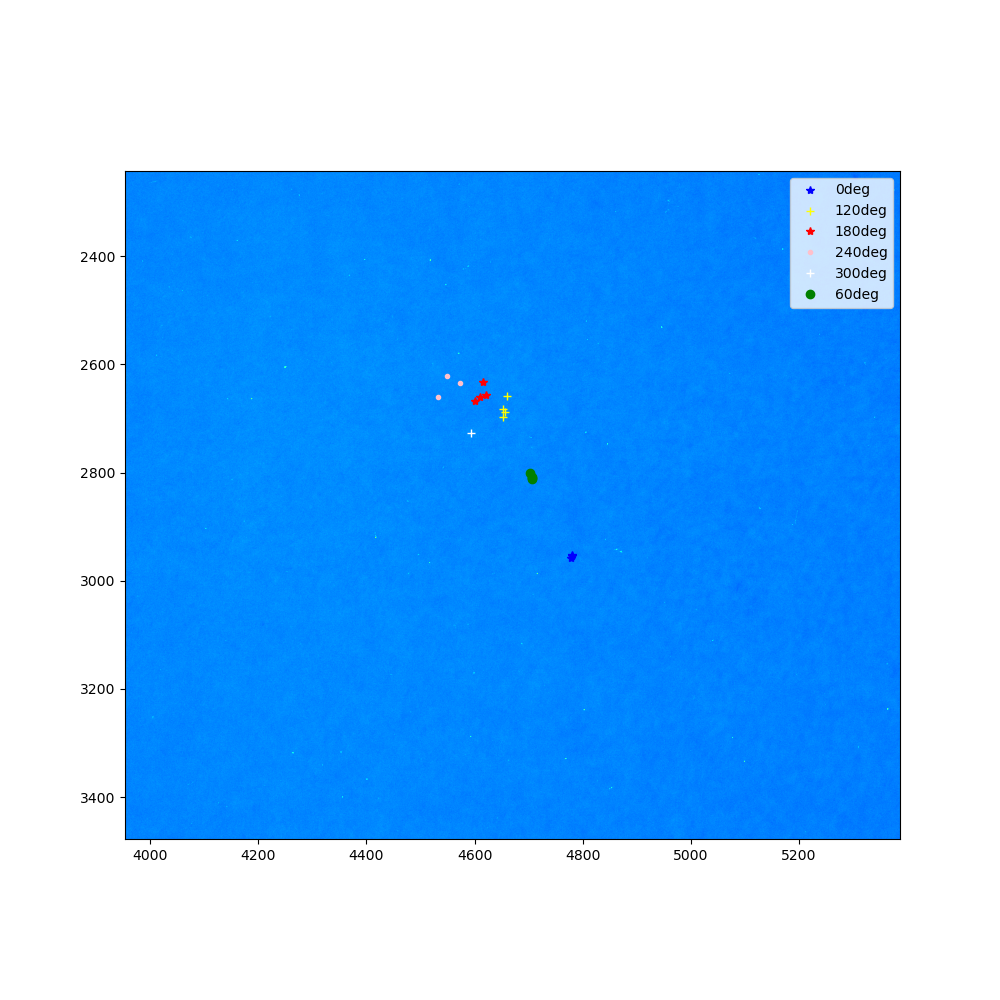

In [131]:
figure = plt.figure(num='Visualize ALL image centers', figsize=(10, 10))

filename = '300deg_nbr1_30s_frames_OB.tif'
image = images[filename]
plt.imshow(image, cmap='jet')

cursor_color = {'300deg': {'color': 'white',
                           'symbol': '+'},
                 '0deg': {'color':'blue',
                          'symbol': '*'},
                 '60deg': {'color': 'green',
                           'symbol': 'o'},
                 '120deg': {'color': 'yellow',
                            'symbol': '+'},
                 '180deg': {'color': 'red',
                            'symbol': '*'},
                 '240deg': {'color': 'pink',
                           'symbol': '.'},
                          }
aperture_label_used = {'300deg': False,
                       '0deg': False,
                       '60deg': False,
                       '120deg': False,
                       '180deg': False,
                       '240deg': False}

for filename in clean_list_label_columns:
    center_x = master_profile_fitted_dict['horizontal_profile.txt'][filename]['center_value']
    center_y = master_profile_fitted_dict['vertical_profile.txt'][filename]['center_value']

    cursor_key = filename_starts_with(filename)
    if not aperture_label_used[cursor_key]:
        plt.plot(center_x, center_y, 
                 cursor_color[cursor_key]['symbol'],
                 color=cursor_color[cursor_key]['color'], 
                 label=cursor_key)
        aperture_label_used[cursor_key] = True
    else:
        plt.plot(center_x, center_y,
                 cursor_color[cursor_key]['symbol'],
                 color=cursor_color[cursor_key]['color'])

#     plt.text(center_x+text_offset, center_y+text_offset,
#              f"x: {center_x} +/- {center_x_error}\ny: {center_y} +/- {center_y_error:.2f}",
#                      horizontalalignment='left',
#              verticalalignment='center',
#              color='white'
#     )
    plt.legend()
    
    
display(HTML('<span style="color:blue">Blue -> 0deg</span>'))
display(HTML('<span style="color:green">Green -> 60deg</span>'))
display(HTML('<span style="color:yellow">Yellow -> 120deg</span>'))
display(HTML('<span style="color:red">Red -> 180deg</span>'))
display(HTML('<span style="color:pink>Pink -> 240deg</span>"'))
display(HTML('<span style="color:black">White -> 300deg</span>'))


## exporting master_fitting_dict 

In [137]:
# data_frame = pd.DataFrame.from_dict(master_profile_fitted_dict)
# data_frame.to_csv("~/Desktop/data.txt")